# Keypoint Detection using Mask R-CNN

In this notebook, we will introduce keypoint detection.  Keypoints are meaningful points of an object detected in an image.  For example, facial or body keypoint detection can be used for emotion and pose recognition.   We will demostrate how to do human body keypoints detection using the pretrained Keypoint R-CNN model in PyTorch.  The Keypoint R-CNN is described in [Mask R-CNN](https://arxiv.org/abs/1703.06870) as well.

## Initialization

In [1]:
# imports
from PIL import Image
import matplotlib.pyplot as plt
import scrapbook as sb
import urllib.request

# torch
import torch
import torchvision

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import data_path
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.detection.data import coco_labels
from utils_cv.detection.model import DetectionLearner, get_pretrained_keypointrcnn
from utils_cv.detection.plot import plot_detections, PlotSettings


# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.3.0
Torch is using GPU: Quadro P400


In [2]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters.

In [3]:
THRESHOLD = 0.5  # discard all detections with confidence score below this threshold
IM_SIZE = 500

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")
device = torch.device("cpu")

Using torch device: cuda


## Prediction with Pre-trained Model

### Preparation

We will use an image from the Internet.

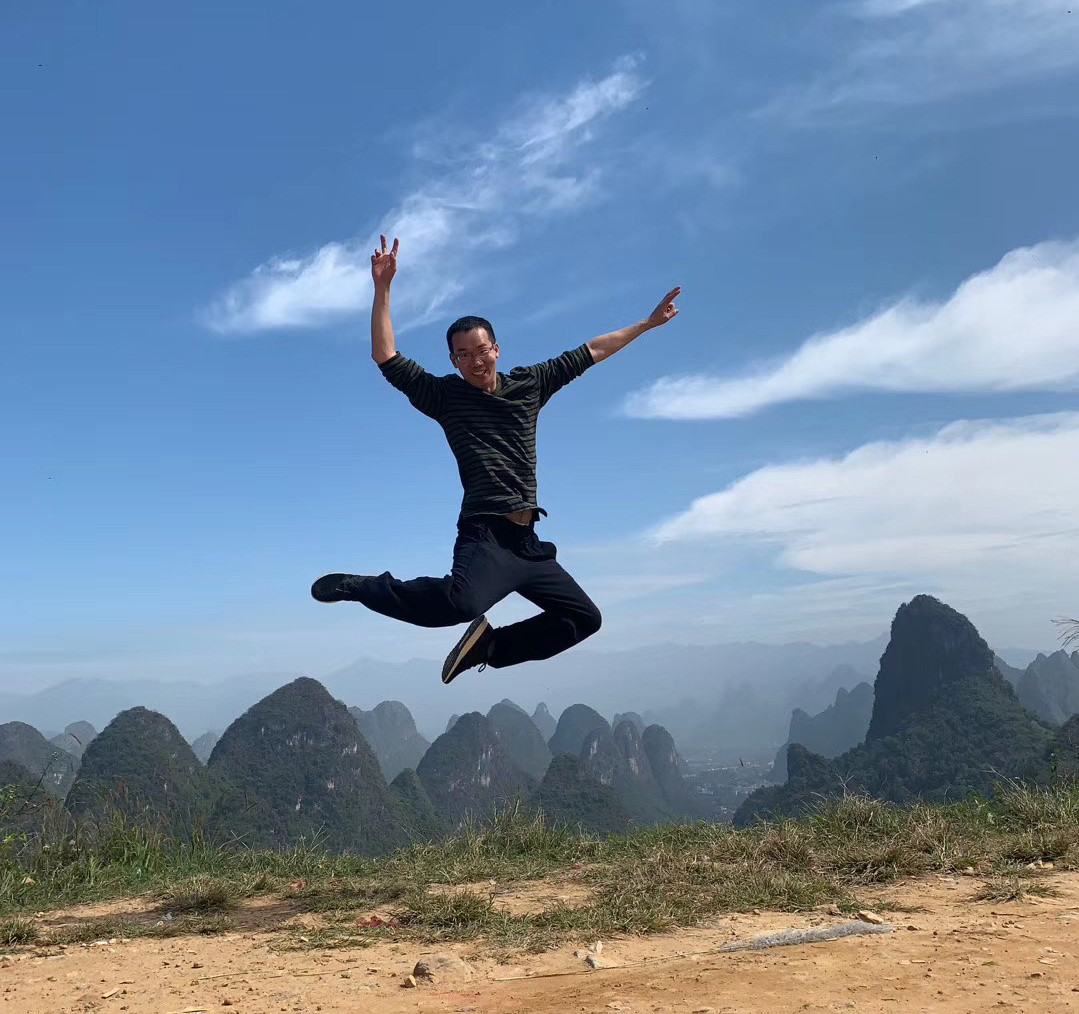

In [4]:
# download image
img_url = "https://cvbp.blob.core.windows.net/public/datasets/object_detection/keypoint_detection.jpg"
img_path = data_path() / img_url.split('/')[-1]
urllib.request.urlretrieve(img_url, img_path)

# show image
Image.open(img_path)

Similar to [01_training_introduction notebook](https://render.githubusercontent.com/view/01_training_introduction.ipynb), we can use `get_pretrained_keypointrcnn()` to get the pretrained Keypoint R-CNN model in PyTorch to create a `DetectionLearner`.

In [5]:
# get pretrained keypoint rcnn model
person_detector = DetectionLearner(
    model=get_pretrained_keypointrcnn(min_size=IM_SIZE, max_size=IM_SIZE),
    labels=coco_labels()[1:],
    device=device,
)

The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

In [6]:
keypoint_labels = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle',
]

Keypoints of an object can be connected by edges in some order for visualization.

In [7]:
keypoint_skeleton = [
    [15, 13],
    [13, 11],
    [16, 14],
    [14, 12],
    [11, 12],
    [5, 11],
    [6, 12],
    [5, 6],
    [5, 7],
    [6, 8],
    [7, 9],
    [8, 10],
    [1, 2],
    [0, 1],
    [0, 2],
    [1, 3],
    [2, 4],
    [3, 5],
    [4, 6],
]

### Prediction

The results from `DetectionLearner.predict()` is a `Dict` contains `det_bboxes` and `keypoints`.

In [8]:
# predict
pred = person_detector.predict(img_path, threshold=THRESHOLD)
pred["det_bboxes"]

[{Bbox object: [left=323, top=239, right=662, bottom=673] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/keypoint_detection.jpg} | score: 0.9998908042907715]

A keypoint is represented by its x and y coordinate as well as visibility in the image.  `0` means invisible.

In [9]:
pred["keypoints"]

array([[[473.2162 , 356.5088 ,   1.     ],
        [479.68228, 347.8616 ,   1.     ],
        [462.43942, 350.02338,   1.     ],
        [494.76978, 350.02338,   1.     ],
        [451.66263, 356.5088 ,   1.     ],
        [524.94476, 386.77402,   1.     ],
        [445.19656, 399.74484,   1.     ],
        [587.4501 , 354.347  ,   1.     ],
        [384.8466 , 356.5088 ,   1.     ],
        [645.6447 , 324.08176,   1.     ],
        [380.53586, 293.8165 ,   1.     ],
        [522.78937, 540.262  ,   1.     ],
        [481.83765, 540.262  ,   1.     ],
        [578.8286 , 618.0869 ,   1.     ],
        [462.43942, 602.9543 ,   1.     ],
        [496.92514, 648.3521 ,   1.     ],
        [365.44836, 587.82166,   1.     ]]], dtype=float32)

### Visualization

Likewise, we can use `plot_detections()` to visulize the predicted bounding boxes and keypoints.  It needs an additional parameter `keypoint_meta` to indicate how to connect the keypoints with edges.

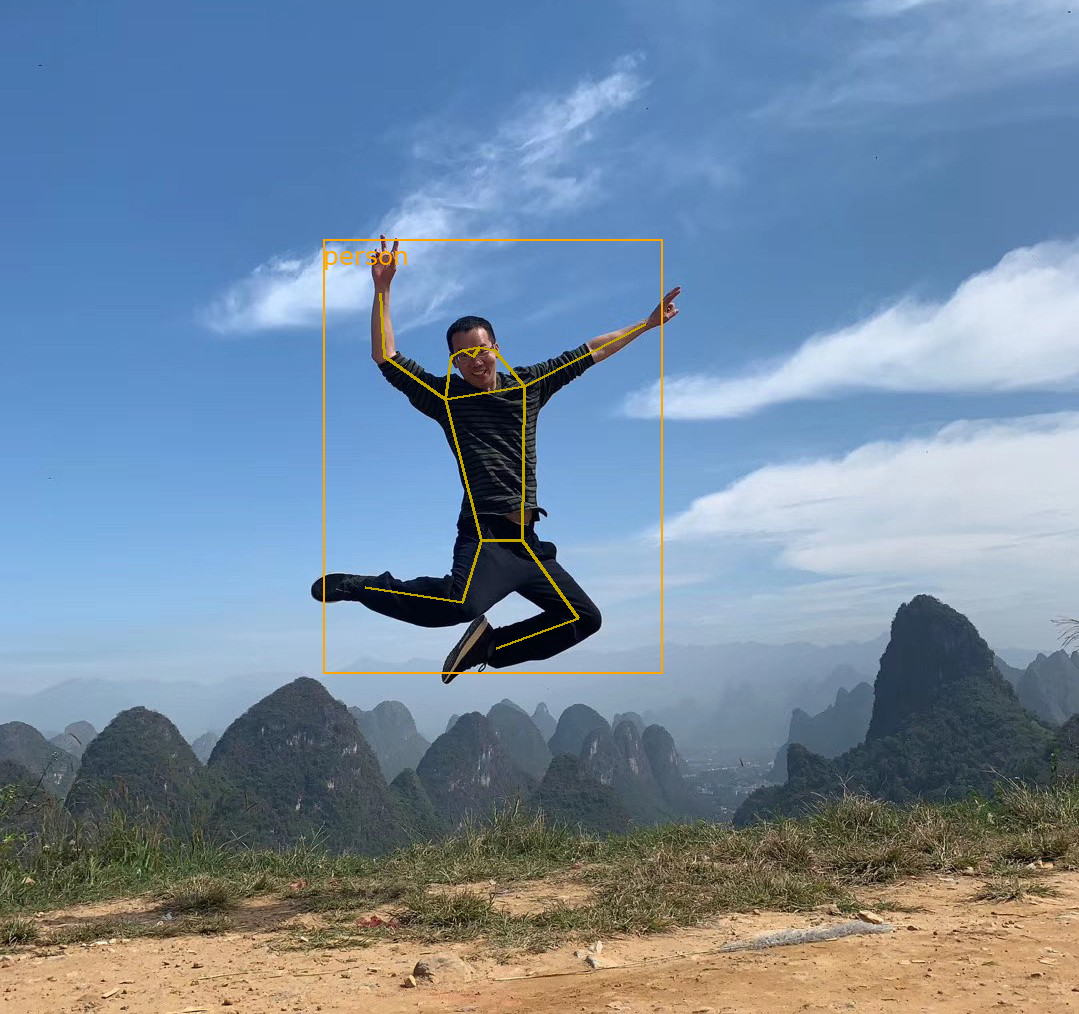

In [10]:
# plot
plot_detections(
    pred,
    keypoint_meta={
        "num_keypoints": len(keypoint_labels),
        "skeleton": keypoint_skeleton,
    },
)

In [11]:
# preserve some of the notebook outputs
sb.glue("keypoints", pred["keypoints"].tolist())
sb.glue("bboxes", [str(x) for x in pred["det_bboxes"]])

## Conclusion

In this notebook, we used the pretrained Keypoint R-CNN model extended from Mask R-CNN to detect keypoints.